In [1]:
from math import sqrt
import numpy as np
import pandas as pd
from collections import defaultdict
import requests

from polara import get_movielens_data
from polara import RecommenderData
from polara import RecommenderModel

from tqdm import tqdm_notebook
%matplotlib inline

# Data

We will use only rating information. The preparation steps are the same as in `polara_intro.ipynb`.

In [2]:
data = get_movielens_data()

In [3]:
data_model = RecommenderData(data, *data.columns[:3], seed=0)
data_model.warm_start = False
data_model.prepare()

Preparing data...
1 unique movieid's within 1 holdout interactions were filtered. Reason: not in the training data.
1 of 1208 userid's were filtered out from holdout. Reason: incompatible number of items.
Done.
There are 996585 events in the training and 3621 events in the holdout.


Check correct fields mapping:

In [4]:
data_model.fields

Fields(userid='userid', itemid='movieid', feedback='rating')

# Popularity baseline

In [5]:
from polara import PopularityModel

In [6]:
pop = PopularityModel(data_model)

In [7]:
pop.build()
pop.evaluate()

Hits(true_positive=432, false_positive=11638, true_negative=None, false_negative=3189)

# Submissions

When your model is ready use the function below to submit your results.  
Use *your name* or some unique label for submission in order to identify your score on the leaderboard.

In [8]:
def save_and_submit(name, recommendations):
    '''Function to submit your model predictions to the leaderboard.
    First argument is the name of the submission, second argument
    is the matrix of top-n recommendations.'''
    np.savez(name, recs=recommendations)
    files = {'upload': open(f'{name}.npz','rb')}
    url = "http://recsysvalley.azurewebsites.net/upload"
    r = requests.post(url, files=files)
    return r.status_code, r.reason

# Warm up - PureSVD model

In [9]:
from polara import SVDModel

In [10]:
svd = SVDModel(data_model)

What would be the procedure to tune SVD?

In [ ]:
# implement tuning procedure

In [11]:
max_rank = 100

In [12]:
svd.rank = max_rank

In [13]:
svd.build()

PureSVD training time: 1.0638344969431301s


In [16]:
svd_res = {}

for rank in tqdm_notebook(range(max_rank, 1, -1)):
    svd.rank = rank
    svd_res[rank] = svd.evaluate().true_positive

HBox(children=(IntProgress(value=0, max=99), HTML(value='')))

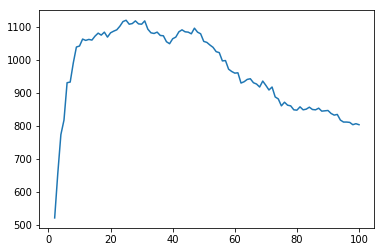

In [17]:
pd.Series(svd_res).sort_index().plot()

In [18]:
svd.rank = pd.Series(svd_res).idxmax()

In [19]:
svd.rank

25

In [21]:
svd.build()

PureSVD training time: 0.24217549144208306s


In [22]:
recs = svd.recommendations

In [23]:
save_and_submit('svd_baseline', recs)

(200, 'OK')

# Modification of PureSVD

In [52]:
from scipy.sparse import diags

class ScaledSVD(SVDModel):
    def __init__(self, *args, **kwargs):
        super(ScaledSVD, self).__init__(*args, **kwargs)
        self.row_scaling = 1 # PureSVD by default
        
    def build(self):
        svd_matrix = self.get_training_matrix()
        row_norm = norm_func(svd_matrix, axis=1, scaling=self.row_scaling) # you have to define norm_func on your own
        new_matrix = diags(row_norm).dot(svd_matrix)
        super(ScaledSVD, self).build(operator=new_matrix)

# iALS (WRMF) model

In order to use this model you need to install an externall library https://github.com/benfred/implicit/.

In [24]:
import os; os.environ["MKL_NUM_THREADS"] = "1" # run only if requested by ImplicitALS

In [25]:
from polara.recommender.external.implicit.ialswrapper import ImplicitALS
from polara.evaluation.pipelines import random_grid
from polara.evaluation.pipelines import set_config

In [26]:
als = ImplicitALS(data_model) # create model

Hyper-parameter tuning can be implemented with random search on a parameter grid.

<img src=random_grid.png/>

You can find more details in: 
*James Bergstra and Yoshua Bengio. “Random search for hyper-parameter optimization”. In: Journal of Machine Learning Research 13.Feb (2012), pp. 281–305.*

In [27]:
als_params = dict(alpha = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
                  #epsilon = [0.01, 0.03, 0.1, 0.3, 1],
                  weight_func = [None, np.sign, np.sqrt, np.log2, np.log10],
                  regularization = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3],
                  rank = range(10, max_rank+1, 10))

In [28]:
als_params_grid = random_grid(als_params, n=60)
len(als_params_grid)

60

In [29]:
als_params_grid

{(0.01, 0.01, <ufunc 'sign'>, 0.1, 40),
 (0.01, 0.01, None, 0.3, 10),
 (0.01, 0.03, <ufunc 'log2'>, 0.003, 30),
 (0.01, 0.03, <ufunc 'sqrt'>, 1, 80),
 (0.01, 0.03, None, 0.001, 30),
 (0.01, 0.1, <ufunc 'log2'>, 0.1, 90),
 (0.01, 0.1, <ufunc 'sign'>, 0.03, 50),
 (0.01, 1, <ufunc 'sign'>, 0.001, 20),
 (0.01, 1, <ufunc 'sqrt'>, 0.001, 80),
 (0.03, 0.3, <ufunc 'log2'>, 0.01, 30),
 (0.03, 0.3, <ufunc 'log2'>, 0.03, 50),
 (0.03, 0.3, None, 0.003, 60),
 (0.03, 1, <ufunc 'log2'>, 0.001, 40),
 (0.03, 1, <ufunc 'log2'>, 0.01, 30),
 (0.1, 0.03, None, 3, 90),
 (0.1, 0.1, <ufunc 'sign'>, 0.1, 20),
 (0.1, 0.3, <ufunc 'log2'>, 0.03, 30),
 (0.1, 1, <ufunc 'log10'>, 0.003, 100),
 (0.1, 1, <ufunc 'log10'>, 1, 50),
 (0.3, 0.01, <ufunc 'log2'>, 1, 80),
 (0.3, 0.01, <ufunc 'sqrt'>, 1, 100),
 (0.3, 0.03, <ufunc 'log2'>, 3, 10),
 (0.3, 0.3, <ufunc 'sign'>, 0.1, 70),
 (0.3, 0.3, <ufunc 'sign'>, 0.3, 60),
 (0.3, 0.3, None, 0.03, 20),
 (0.3, 1, <ufunc 'sqrt'>, 0.03, 40),
 (0.3, 1, None, 0.03, 50),
 (1, 0.01, <u

In [30]:
als.verbose = False

als_grid_results = defaultdict(dict)
for params in tqdm_notebook(als_params_grid):
    set_config(als, als_params.keys(), params)
    als.build()
    als_grid_results[params] = als.evaluate('hits').true_positive

HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

In [31]:
als_res = pd.Series(data=list(als_grid_results.values()), index=list(als_grid_results.keys()))

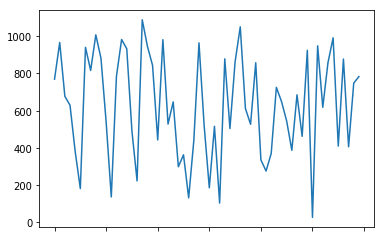

In [32]:
als_res.plot()

In [33]:
als_res.idxmax()

(0.01, 0.03, None, 0.001, 30)

Don't forget to apply the best configuration:

In [35]:
set_config(als, als_params.keys(), als_res.idxmax())

In [36]:
als.build()
als_recs = als.recommendations

In [38]:
save_and_submit('als_baseline', als_recs)

(200, 'OK')

# SGD-based Matrix Factorization

In [39]:
from polara.lib.optimize import sgd_step

In [40]:
sgd_step??

In [41]:
def unbiased_sgdmf(user_idx, item_idx, feedback,
                   rank=10, lrate=0.005, reg=0.05,
                   num_epochs=25, tol=1e-4,
                   seed=None, verbose=True):
    '''The main function to iterate over epochs in SGD approach.
    '''
    n_users = user_idx.max() + 1
    n_items = item_idx.max() + 1
    
    # initialization with random numbers
    random_state = np.random.RandomState(seed) if seed else np.random
    P = random_state.normal(scale=0.1, size=(n_users, rank))
    Q = random_state.normal(scale=0.1, size=(n_items, rank))
        
    last_err = np.finfo(np.float64).max
    for epoch in range(num_epochs):
        # make a single SGD step
        new_err = sgd_step(user_idx, item_idx, feedback, P, Q, lrate, reg)
        
        # control the progress by calculating error
        err_delta = abs(last_err - new_err) / last_err
        
        if verbose:
            rmse = sqrt(new_err / len(feedback))
            print('Epoch {} RMSE: {}'.format(epoch+1, rmse))
        
        last_err = new_err
        if err_delta < tol:
            break
    return P, Q

In [42]:
class SGDMatrixFactorization(RecommenderModel):
    '''This is a full implementation of the basic
    matrix factorization based on stochastic gradient descent.
    It uses folding-in approach to recommend items for test users.'''
    
    def __init__(self, *args, **kwargs):
        super(SGDMatrixFactorization, self).__init__(*args, **kwargs)
        self.rank = 10
        self.lrate = 0.005 # learning rate
        self.reg = 0.05 # regularization constant
        self.num_epochs = 25
        self.tol = 1e-4
        self.verbose = True
        self.seed = 0
        self.method = 'SGD-MF'
        self.factors = dict.fromkeys(self.data.fields[:2]) # for user and item factors
    
    def build(self):
        userid, itemid, feedback = self.data.fields
        
        trainset = self.data.training.sample(frac=1, random_state=self.seed) # shuffle data
        useridx = trainset[userid].values
        itemidx = trainset[itemid].values
        feedback = trainset[feedback].values
        # sgd learning parameters
        config = dict(rank=self.rank,
                      lrate=self.lrate,
                      reg=self.reg,
                      num_epochs=self.num_epochs,
                      tol=self.tol,
                      seed=self.seed,
                      verbose=self.verbose)
        # performing sgd
        user_factors, item_factors = unbiased_sgdmf(useridx, itemidx, feedback,
                                                    **config)
        # store learned factor matrices
        self.factors[userid] = user_factors
        self.factors[itemid] = item_factors
    
    
    def slice_recommendations(self, test_data, shape, start, stop, test_users=None):
        slice_data = self._slice_test_data(test_data, start, stop)
        
        P = self.factors[self.data.fields.userid]
        Q = self.factors[self.data.fields.itemid]
                
        scores = P[test_users[start:stop], :].dot(Q.T)
        return scores, slice_data

In [43]:
sgd = SGDMatrixFactorization(data_model)

In [44]:
sgd.build()

Epoch 1 RMSE: 3.1138870760100064
Epoch 2 RMSE: 1.1758488700450915
Epoch 3 RMSE: 0.9785639902085602
Epoch 4 RMSE: 0.938434293945442
Epoch 5 RMSE: 0.9223711466510817
Epoch 6 RMSE: 0.91233427950537
Epoch 7 RMSE: 0.9042884469429985
Epoch 8 RMSE: 0.8975013266670964
Epoch 9 RMSE: 0.8917823800316249
Epoch 10 RMSE: 0.8868114068917887
Epoch 11 RMSE: 0.8822542928007012
Epoch 12 RMSE: 0.8778881732359765
Epoch 13 RMSE: 0.8736152630666294
Epoch 14 RMSE: 0.8694268328266208
Epoch 15 RMSE: 0.8653574104298472
Epoch 16 RMSE: 0.8614509456742989
Epoch 17 RMSE: 0.8577441868388446
Epoch 18 RMSE: 0.8542609869388811
Epoch 19 RMSE: 0.8510113648470508
Epoch 20 RMSE: 0.8479929575680334
Epoch 21 RMSE: 0.8451938878603104
Epoch 22 RMSE: 0.8425960984391513
Epoch 23 RMSE: 0.8401784577014748
Epoch 24 RMSE: 0.8379193276083767
Epoch 25 RMSE: 0.8357984829688259


In [45]:
sgd_recs = sgd.recommendations

In [46]:
save_and_submit('sgd_baseline', sgd_recs)

(200, 'OK')